# Function Definition

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
from keras import utils as np_utils

Using TensorFlow backend.


In [3]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

In [4]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

In [5]:
def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

In [6]:
def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

In [7]:
def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

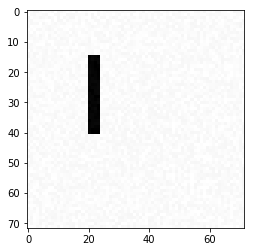

In [8]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

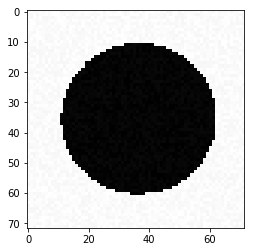

In [9]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

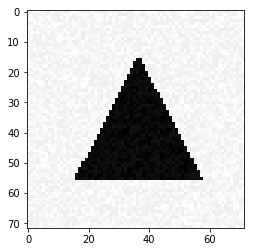

In [10]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [11]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


In [12]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [13]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [14]:
import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

In [15]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# Simple Classification

## Build and train classifier

In [16]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.utils import to_categorical

In [17]:
# Generate a training set of images
# Label 0 = rectangle, 1 = disk, 2 = triangle
[X_train, Y_train] = generate_dataset_classification(300,20)

# Change Y_train to categorical value
label_train = to_categorical(Y_train)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


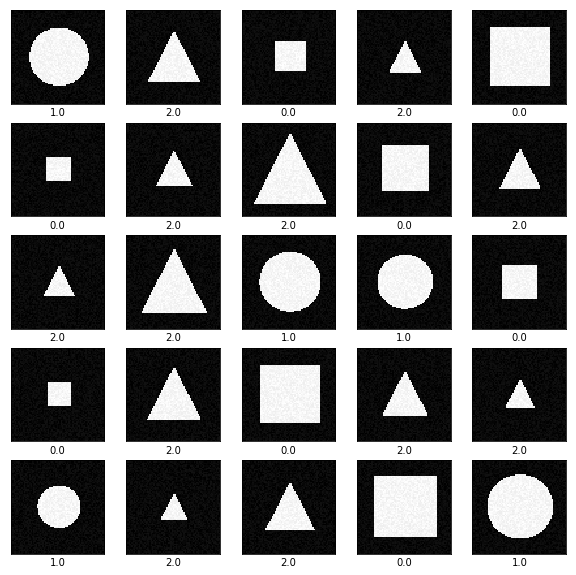

In [18]:
# plot the training data to ensure its correctness
plt.figure(figsize=(10,10))
for i in range(25):
    im = X_train[i]
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap=plt.cm.binary)
    plt.xlabel(Y_train[i])

In [19]:
# Create classifier with 2 layers
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(5184,)),
    keras.layers.Dense(3,activation=tf.nn.softmax)
])

In [20]:
# Try SGD optimizer
#model.compile(optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.1),
#              loss = 'mean_squared_error',
#               metrics=['accuracy'])

In [21]:
#try Adam optimizer
model.compile(optimizer=tf.train.AdamOptimizer(),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

In [22]:
model.fit(X_train, Y_train, epochs=10)

Epoch 1/10
300/300 [==============================] - 0s 432us/step - loss: 1.7937 - acc: 0.4033
Epoch 2/10
300/300 [==============================] - 0s 136us/step - loss: 1.0355 - acc: 0.5267
Epoch 3/10
300/300 [==============================] - 0s 160us/step - loss: 0.6487 - acc: 0.6933
Epoch 4/10
300/300 [==============================] - 0s 170us/step - loss: 0.4352 - acc: 0.8633
Epoch 5/10
300/300 [==============================] - 0s 160us/step - loss: 0.3854 - acc: 0.8200
Epoch 6/10
300/300 [==============================] - 0s 180us/step - loss: 0.3331 - acc: 0.8767
Epoch 7/10
300/300 [==============================] - 0s 153us/step - loss: 0.2683 - acc: 0.9233
Epoch 8/10
300/300 [==============================] - 0s 160us/step - loss: 0.2927 - acc: 0.8667
Epoch 9/10
300/300 [==============================] - 0s 156us/step - loss: 0.2245 - acc: 0.9300
Epoch 10/10
300/300 [==============================] - 0s 153us/step - loss: 0.1836 - acc: 0.9867


1

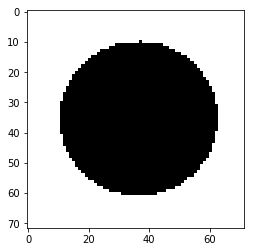

In [23]:
#Checking the classifier
# Generate a test data. Here's a disk, which lable should be 1
X_test = generate_a_disk()
plt.imshow(X_test.reshape(72,72), cmap='gray')
X_test = X_test.reshape(1, X_test.shape[0])

# predict the test data and get the label
predictions = model.predict(X_test)
np.argmax(predictions)

# The result is 1, which is correct

## Visualize solution

In [24]:
weight = model.get_weights()
weight_1 = weight[0]
weight_1

array([[-0.01250874, -0.00362868,  0.03223609],
       [-0.02386588, -0.0305122 , -0.01341423],
       [-0.03183197,  0.00538769, -0.00357478],
       ...,
       [ 0.01519891, -0.01617311, -0.00830908],
       [-0.02393635, -0.01828504,  0.00719807],
       [-0.00217916,  0.01869504,  0.00812473]], dtype=float32)

In [40]:
import pandas as pd
weight_11 = pd.DataFrame(weight_1)

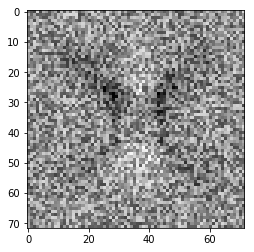

In [41]:
# As stated above, Label 0 = rectangle, 1 = disk, 2 = triangle
# Rectangle
col_1 = weight_11.iloc[:,0]
plt.imshow(col_1.values.reshape(72,72),cmap='gray')

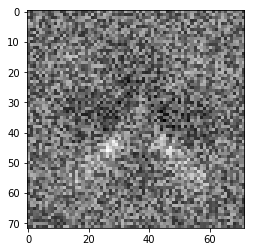

In [42]:
# Disk
col_2 = weight_11.iloc[:,1]
plt.imshow(col_2.values.reshape(72,72),cmap='gray')

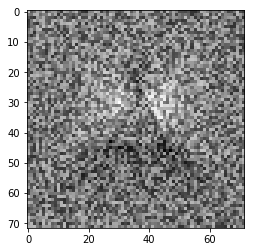

In [43]:
# Triangle
col_3 = weight_11.iloc[:,2]
plt.imshow(col_3.values.reshape(72,72),cmap='gray')

# A More Difficult Classification Problem

In [56]:
#Generate a new training data set
[X_train1, Y_train1] = generate_dataset_classification(300, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [57]:
#Generate test data set to evaluate the model
[X_test1, Y_test1] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


## Train CNN

In [70]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten
from keras.callbacks import EarlyStopping

In [64]:
#reformatting the input
X_train1 = X_train1.reshape(len(X_train1),72,72,1)
X_train1 = X_train1.astype('float32')
X_test1 = X_test1.reshape(len(X_test1),72,72,1)
X_test1 = X_test1.astype('float32')
X_train1.shape

(300, 72, 72, 1)

In [60]:
#reformatting the output
label_train = to_categorical(Y_train1)
label_test = to_categorical(Y_test1)
label_train.shape

(300, 3)

In [66]:
#creating the model
model_cnn = Sequential()
model_cnn.add(Conv2D(10,3,3,border_mode='same',activation = 'relu', input_shape=(72,72,1)))

model_cnn.add(MaxPooling2D(pool_size=(2,2)))


model_cnn.add(Flatten())

model_cnn.add(Dense(3, activation='softmax'))

D:\Anaconda\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (3, 3), activation="relu", input_shape=(72, 72, 1..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
# model.compile
model_cnn.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [71]:
# fit the model
early_stopping_monitor = EarlyStopping(patience=3)
model_cnn.fit(X_train1,label_train , batch_size= 32 ,validation_split=0.3, epochs=100, callbacks = [early_stopping_monitor], verbose=1)

Train on 210 samples, validate on 90 samples
Epoch 1/100
210/210 [==============================] - 1s 3ms/step - loss: 1.2557 - acc: 0.2905 - val_loss: 1.0498 - val_acc: 0.4444
Epoch 2/100
210/210 [==============================] - 0s 2ms/step - loss: 1.0518 - acc: 0.3762 - val_loss: 0.9991 - val_acc: 0.5889
Epoch 3/100
210/210 [==============================] - 0s 2ms/step - loss: 0.9256 - acc: 0.7000 - val_loss: 0.9603 - val_acc: 0.5444
Epoch 4/100
210/210 [==============================] - 0s 2ms/step - loss: 0.8452 - acc: 0.6857 - val_loss: 0.9164 - val_acc: 0.5778
Epoch 5/100
210/210 [==============================] - 0s 2ms/step - loss: 0.7771 - acc: 0.7857 - val_loss: 0.8711 - val_acc: 0.6556
Epoch 6/100
210/210 [==============================] - 0s 2ms/step - loss: 0.6963 - acc: 0.8095 - val_loss: 0.8497 - val_acc: 0.6444
Epoch 7/100
210/210 [==============================] - 0s 2ms/step - loss: 0.6371 - acc: 0.8619 - val_loss: 0.8306 - val_acc: 0.6556
Epoch 8/100
210/210 [===

In [72]:
#testing
model_cnn.evaluate(X_test1, Y_test1)

300/300 [==============================] - 0s 851us/step


[0.7664759174982707, 0.6266666666666667]